In [23]:
### READING THE DATASET

import pandas as pd
import os as os
import numpy as np
# Creating empty list for broken tooth and healthy gearbox datasets
broken = []
healthy = []

# Defining the path where the datasets are stored
pth1 = 'dataset/BrokenTooth'
pth2 = 'dataset/Healthy'

# Reading the dataset as the list items using the OS library to access the files and read_csv function from pandas to read the daatasets 
# **Reading each file in the BrokenTooth and Healthy directories and appending it to the respective lists as pandas' DataFrame object (abbr.: df)
for file_name in sorted(os.listdir(pth1)):
    this_df = pd.read_csv(os.path.join(pth1, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 0
    broken.append(this_df)

for file_name in sorted(os.listdir(pth2)):
    this_df = pd.read_csv(os.path.join(pth2, file_name))
    this_df['load'] = 10*int(file_name[5])
    this_df['gearbox_status'] = 1
    healthy.append(this_df)

In [24]:
# Aggregating dataset based on health status
# broken_agg = broken[0]
# healthy_agg = healthy[0]
# for i in range(1,10):
#     broken_agg = pd.concat([broken_agg, broken[i]], ignore_index=True)
#     healthy_agg = pd.concat([healthy_agg, healthy[i]], ignore_index=True)

In [27]:
import math

def divide_into(df, n):
    group_size = n
    df_groups = []
    for i in range(math.ceil(df['a1'].count()/group_size)):
        new_df = df.iloc[i*group_size:(i+1)*group_size, :]
        df_groups.append(new_df)
    return df_groups

def get_group_stdevs(df, n):
    groups = divide_into(df, n)
    stdevs = pd.DataFrame(map(pd.DataFrame.std, groups))
    stdevs['load'] = df['load']
    stdevs['gearbox_status'] = df['gearbox_status']
    
    return stdevs

broken_stdev = []
for i in range(0,10):
    broken_stdev.append(get_group_stdevs(broken[i], 100))

healthy_stdev = []
for i in range(0,10):
    healthy_stdev.append(get_group_stdevs(healthy[i], 100))

           a1        a2        a3        a4  load  gearbox_status
0    5.178408  5.534030  5.368494  5.665968    30               0
1    4.277515  4.039146  4.119412  4.148621    30               0
2    2.874628  3.474401  3.175718  2.920996    30               0
3    3.390684  3.455118  2.970112  3.334487    30               0
4    3.868169  3.979720  3.621905  4.327168    30               0
..        ...       ...       ...       ...   ...             ...
894  4.934639  4.614853  4.536547  5.837843    30               0
895  4.078120  4.067854  3.883442  3.985121    30               0
896  4.037747  3.578898  3.573310  4.393785    30               0
897  4.181590  3.476764  3.603086  2.896070    30               0
898  3.339255  2.454560  2.286381  2.062421    30               0

[899 rows x 6 columns]
             a1        a2        a3        a4  load  gearbox_status
0      6.722006  3.798253  3.494062  4.340654    30               1
1      6.969772  2.950190  3.933455  4.042469   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

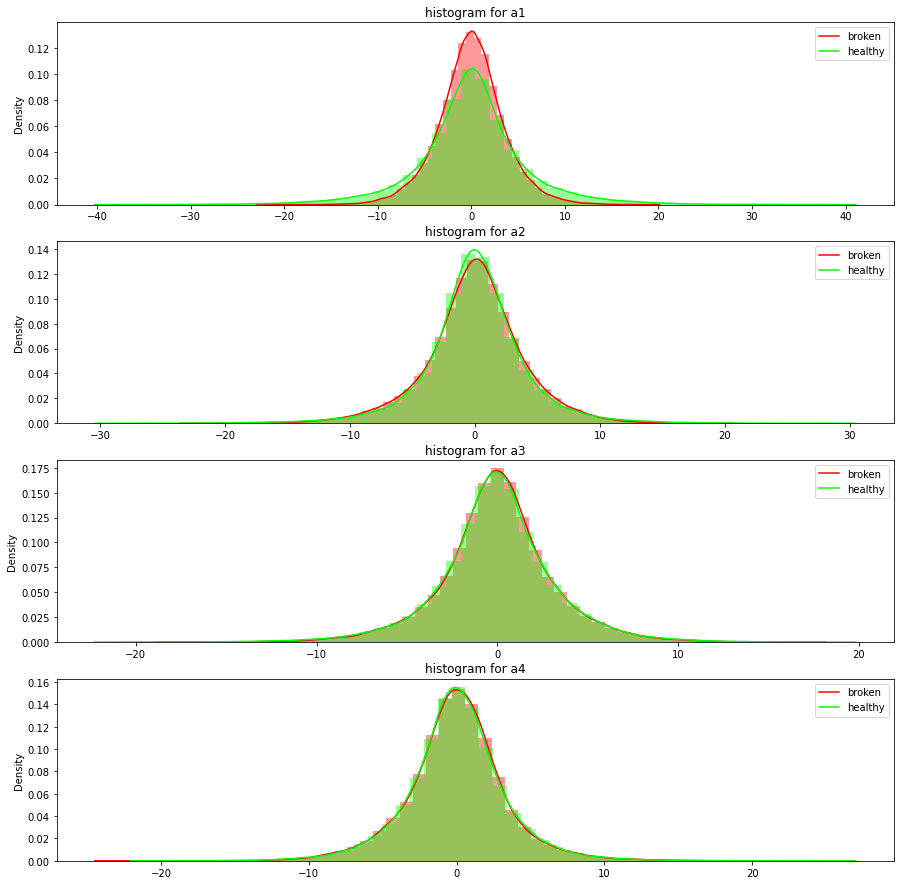

In [26]:
### DATA VISUALISATION

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

load = 0
dataset = pd.concat([broken[load], healthy[load]], axis=0)

plt.figure(figsize=(15,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(dataset[['a1','a2','a3','a4']]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset[cn][dataset.gearbox_status == 0], bins=50, color="red")
    sns.distplot(dataset[cn][dataset.gearbox_status == 1], bins= 50, color="lime")
    ax.set_xlabel('')
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(cn))
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

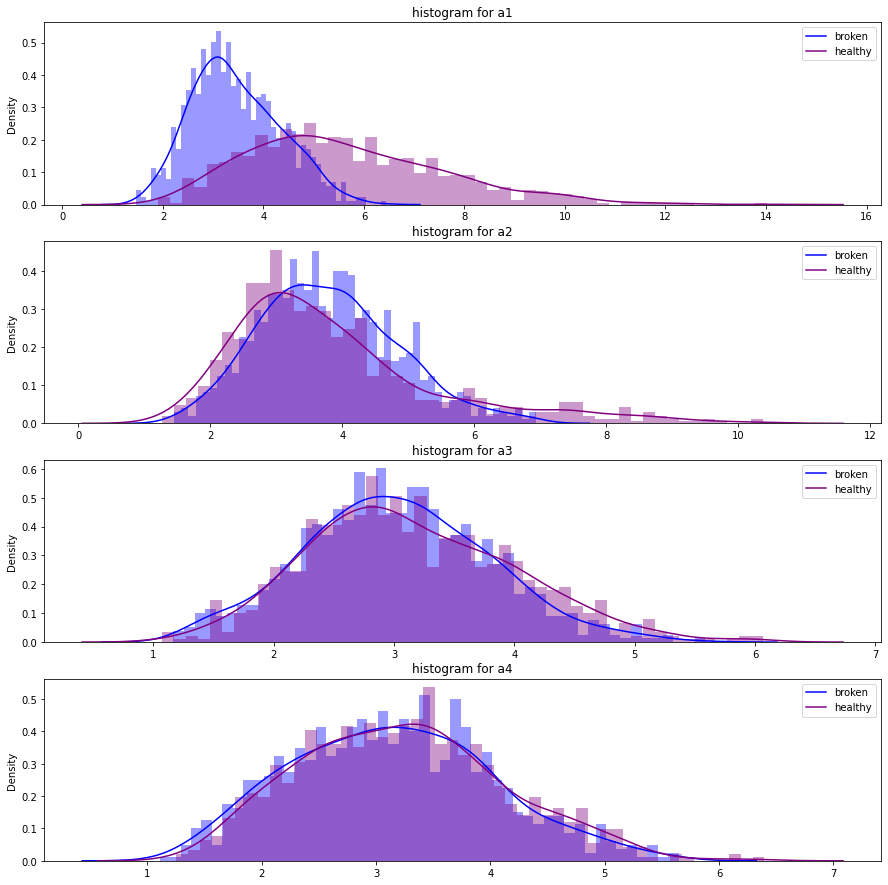

In [30]:
load = 0
dataset_stdev = pd.concat([broken_stdev[load], healthy_stdev[load]], axis=0)

plt.figure(figsize=(15,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(dataset_stdev[['a1','a2','a3','a4']]):
    ax = plt.subplot(gs[i])
    sns.distplot(dataset_stdev[cn][dataset_stdev.gearbox_status == 0], bins=50, color="blue")
    sns.distplot(dataset_stdev[cn][dataset_stdev.gearbox_status == 1], bins= 50, color="purple")
    ax.set_xlabel('')
    plt.legend(['broken', 'healthy'])
    ax.set_title('histogram for ' + str(cn))
plt.show()